Risk Prediction Using Tree-based Models
-------------------------------------------

**Objective: To use tree based machine learning models to predict the 10-year risk of death of individuals from the NHANES epidemiology dataset**

This project covers the following key concepts
* Dealing with missing data
    * Complete case analysis
    * Imputation
* Decision Trees
    * Evaluation
    * Regularization
* Random Forests
    * Hyperparameter Tuning

### Import Packages

In [1]:
import shap
import sklearn
import itertools
import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import lifelines

from IPython.display import Image 

from six import StringIO
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

### Load Dataset and Preprocess

In [19]:
X = pd.read_csv('Data/NHANESI_subset_X.csv')

# y is the survival time data. Positive numbers indicate time period of death
# Negative numbers mean death=False
y = pd.read_csv('Data/NHANESI_subset_y.csv')['y']
y = np.array(y)

threshold = 10

df = X.drop([X.columns[0]], axis=1)

# extract data between +/- 10
df.loc[:, 'time'] = y
df.loc[:, 'death'] = np.ones(len(X))
df.loc[df.time < 0, 'death'] = 0
df.loc[:, 'time'] = np.abs(df.time)

df = df.dropna(axis='rows')

# cond1: dead or alive for more than 10 years
# cond2: dead
# final: dead irrespective of time or alive for more than 10 years
# remove people who are alive and below the threshold
mask = (df.time > threshold) | (df.death == 1)
df = df[mask]
X = df.drop(['time', 'death'], axis='columns')

# predicting 10 year death risk
# if dead in under 10 years, y = TRUE
# if dead in over 10 years or alive, y = FALSE
y = df.time < threshold    

In [20]:
# intentionally setting systolic BP for a certain population to NaN
def prob_drop(age):
    return 1 - (np.exp(0.25 * age - 5) / (1 + np.exp(0.25 * age - 5)))

X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
feature_y = 'Systolic BP'
frac = 0.7

drop_rows = X_dev.sample(frac=frac, replace=False,
                         weights=[prob_drop(X_dev.loc[i, 'Age']) for i in
                                  X_dev.index], random_state=10)

X_dev.loc[drop_rows.index, feature_y] = None

# 75/25 test validation split
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, random_state=10)

### Exploratory Data Analysis

In [22]:
print("X_train shape: {}".format(X_train.shape))
X_train.head()

X_train shape: (5147, 18)


,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
1599,43.0,84.0,637.0,1.0,49.3,10.0,5.0,253.0,134.0,1.59,7.7,1.0,NaN,490.0,27.3,9.1,25.803007,34.0
2794,72.0,96.0,154.0,2.0,43.4,23.0,4.3,265.0,106.0,1.66,6.8,2.0,208.0,301.0,35.2,6.0,33.394319,112.0
1182,54.0,78.0,205.0,1.0,43.8,12.0,4.2,206.0,180.0,1.67,6.6,2.0,NaN,363.0,49.6,5.9,20.278410,34.0
6915,59.0,90.0,417.0,1.0,43.4,9.0,4.5,327.0,114.0,1.65,7.6,2.0,NaN,347.0,32.9,6.1,32.917744,78.0
500,34.0,80.0,385.0,1.0,77.7,9.0,4.1,197.0,64.0,1.74,7.3,2.0,NaN,376.0,17.0,8.2,30.743489,30.0


In [23]:
y_train.head(20)

1599    False
2794     True
1182    False
6915    False
500     False
1188     True
9739    False
3266    False
6681    False
8822    False
5856     True
3415    False
9366    False
7975    False
1397    False
6809    False
9461    False
9374    False
1170     True
158     False
Name: time, dtype: bool

In [24]:
i = 25
print(X_train.iloc[i,:])
print("\nDied within 10 years? {}".format(y_train.loc[y_train.index[i]]))

Age                    73.000000
Diastolic BP           88.000000
Poverty index          68.000000
Race                    2.000000
Red blood cells        42.100000
Sedimentation rate     19.000000
Serum Albumin           3.600000
Serum Cholesterol     215.000000
Serum Iron             64.000000
Serum Magnesium         1.590000
Serum Protein           5.700000
Sex                     2.000000
Systolic BP           190.000000
TIBC                  334.000000
TS                     19.200000
White blood cells       6.600000
BMI                    31.880432
Pulse pressure        102.000000
Name: 7331, dtype: float64

Died within 10 years? True


### Missing Data

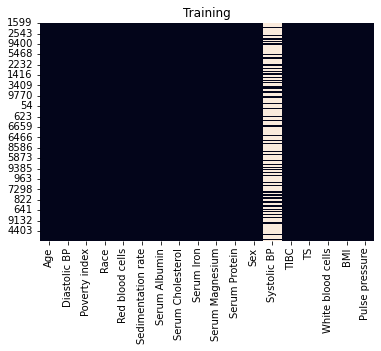

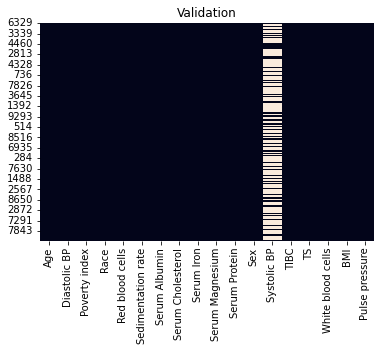

In [25]:
sns.heatmap(X_train.isnull(), cbar=False)
plt.title("Training")
plt.show()

sns.heatmap(X_val.isnull(), cbar=False)
plt.title("Validation")
plt.show()

In [26]:
def fraction_rows_missing(df):
    '''
    Return percent of rows with any missing
    data in the dataframe. 
    
    Input:
        df (dataframe): a pandas dataframe with potentially missing data
    Output:
        frac_missing (float): fraction of rows with missing data
    '''
    ### START CODE HERE (REPLACE 'Pass' with your 'return' code) ###
    return (1 - df_test.dropna().shape[0]/df.shape[0])

df_test = pd.DataFrame({'a':[None, 1, 1, None], 'b':[1, None, 0, 1]})
print("Example dataframe:\n")
print(df_test)

print("\nComputed fraction missing: {}, expected: {}".format(fraction_rows_missing(df_test), 0.75))
print(f"Fraction of rows missing from X_train: {fraction_rows_missing(X_train):.3f}")
print(f"Fraction of rows missing from X_val: {fraction_rows_missing(X_val):.3f}")
print(f"Fraction of rows missing from X_test: {fraction_rows_missing(X_test):.3f}")

Example dataframe:

     a    b
0  NaN  1.0
1  1.0  NaN
2  1.0  0.0
3  NaN  1.0

Computed fraction missing: 0.75, expected: 0.75
Fraction of rows missing from X_train: 1.000
Fraction of rows missing from X_val: 0.999
Fraction of rows missing from X_test: 0.999


### Complete Case Analysis

In [27]:
# drop all rows with any missing data
X_train_dropped = X_train.dropna(axis='rows')
y_train_dropped = y_train.loc[X_train_dropped.index]
X_val_dropped = X_val.dropna(axis='rows')
y_val_dropped = y_val.loc[X_val_dropped.index]

X_val_dropped

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
6329,69.0,80.0,238.0,1.0,77.7,19.0,4.1,186.0,140.0,1.67,7.8,2.0,140.0,531.0,26.4,3.9,21.187152,60.0
727,65.0,64.0,92.0,2.0,52.8,24.0,4.2,254.0,154.0,1.43,8.2,2.0,160.0,332.0,46.4,11.9,26.242086,96.0
6788,63.0,80.0,53.0,2.0,50.7,3.0,4.1,195.0,93.0,1.83,6.9,1.0,140.0,302.0,30.8,7.4,19.259704,60.0
7487,55.0,90.0,384.0,1.0,53.9,16.0,4.4,246.0,102.0,1.79,7.0,1.0,138.0,306.0,33.3,7.9,29.495437,48.0
847,63.0,102.0,824.0,1.0,48.7,3.0,4.5,228.0,145.0,1.70,7.1,1.0,150.0,313.0,46.3,6.7,36.830913,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3603,69.0,110.0,343.0,1.0,46.1,42.0,4.2,296.0,100.0,1.61,6.8,2.0,205.0,348.0,28.7,6.0,31.237379,95.0
7476,66.0,98.0,293.0,1.0,47.4,10.0,4.4,307.0,96.0,1.82,6.6,2.0,150.0,313.0,30.7,5.1,21.396533,52.0
395,64.0,80.0,138.0,1.0,77.7,26.0,4.6,366.0,130.0,1.65,8.3,2.0,132.0,281.0,46.3,8.0,29.663866,52.0
6281,71.0,116.0,200.0,1.0,44.4,29.0,4.3,279.0,55.0,2.01,6.8,2.0,186.0,344.0,16.0,6.8,22.583144,70.0


### Concordance Index

In [29]:
def cindex(y_true, scores):
    return lifelines.utils.concordance_index(y_true, scores)

### Decision Tree (baseline)

In [31]:
dt = DecisionTreeClassifier(max_depth=None, random_state=10)
dt.fit(X_train_dropped, y_train_dropped)

y_train_preds = dt.predict_proba(X_train_dropped)[:, 1]
print(f"Train C-Index: {cindex(y_train_dropped.values, y_train_preds)}")

y_val_preds = dt.predict_proba(X_val_dropped)[:, 1]
print(f"Val C-Index: {cindex(y_val_dropped.values, y_val_preds)}")

Train C-Index: 1.0
Val C-Index: 0.5629321808510638


### Decision Tree (tuned)

In [52]:
dt_hyperparams = {'min_samples_split':0.2,
                  'max_depth':3
                 }

dt_reg = DecisionTreeClassifier(**dt_hyperparams, random_state=10)
dt_reg.fit(X_train_dropped, y_train_dropped)

y_train_preds = dt_reg.predict_proba(X_train_dropped)[:, 1]
print(f"Train C-Index: {cindex(y_train_dropped.values, y_train_preds)}")

y_val_preds = dt_reg.predict_proba(X_val_dropped)[:, 1]
print(f"Val C-Index: {cindex(y_val_dropped.values, y_val_preds)}")

Train C-Index: 0.6780135398312158
Val C-Index: 0.6247340425531915


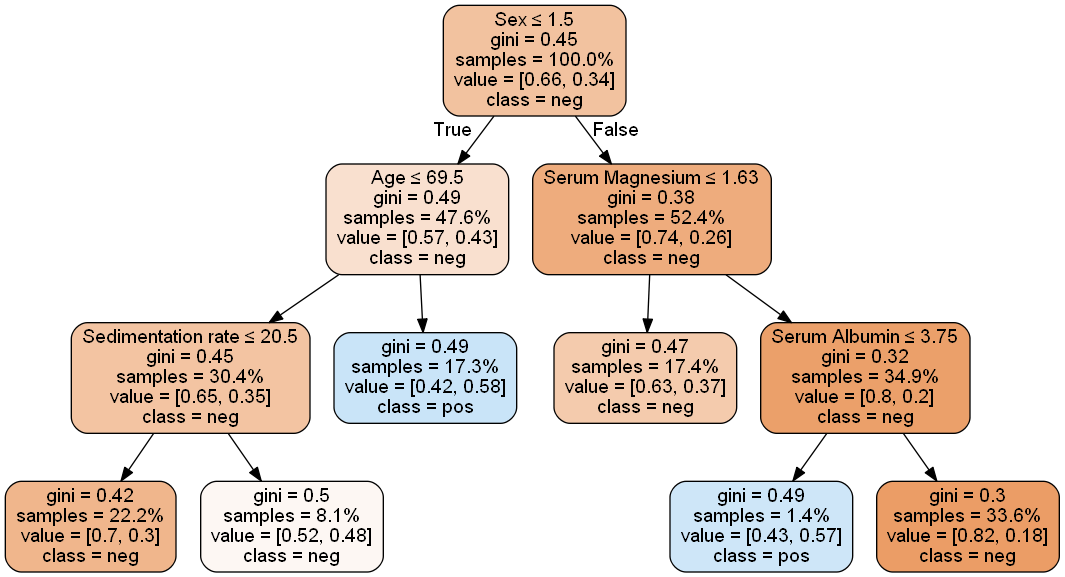

In [53]:
dot_data = StringIO()
export_graphviz(dt_reg, feature_names=X_train_dropped.columns, out_file=dot_data,  
                filled=True, rounded=True, proportion=True, special_characters=True,
                impurity=True, class_names=['neg', 'pos'], precision=2)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())